Memory usage: 30.68517780303955 MB


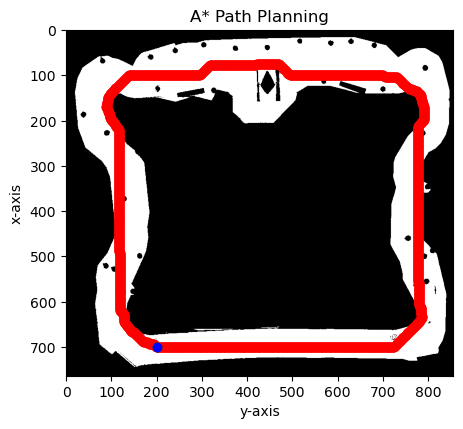

In [10]:
import numpy as np
import heapq
import matplotlib.pyplot as plt
import csv
import time
import tracemalloc

class Node:
    def __init__(self, position, parent=None):
        self.position = position
        self.parent = parent
        self.g = 0   
        self.h = 0   
        self.f = 0   

    def __eq__(self, other):
        return self.position == other.position

    def __lt__(self, other):
        return self.f < other.f

def heuristic(a, b):
    return abs(a[0] - b[0]) + abs(a[1] - b[1])

def astar(grid, start, goal):
    directions = [(0, 1), (1, 0), (0, -1), (-1, 0), (-1,1), (1,1), (1,-1), (-1,-1)]
    open_list = []
    closed_list = set()
    heapq.heappush(open_list, (0 + heuristic(start, goal), 0, start, None))
    g_costs = {start: 0}
    came_from = {start: None}
    
    while open_list:
        _, current_cost, current, parent = heapq.heappop(open_list)
        
        if current in closed_list:
            continue
        
        closed_list.add(current)
        came_from[current] = parent
        
        if current == goal:
            break
        
        for direction in directions:
            neighbor = (current[0] + direction[0], current[1] + direction[1])
            if 0 <= neighbor[0] < grid.shape[0] and 0 <= neighbor[1] < grid.shape[1]:
                if grid[neighbor[0], neighbor[1]] == 0 and neighbor not in closed_list:
                    if is_collision_free(grid, current, neighbor):
                        move_cost = np.sqrt(direction[0]**2 + direction[1]**2)
                        tentative_g_cost = current_cost + move_cost
                        if neighbor not in g_costs or tentative_g_cost < g_costs[neighbor]:
                            g_costs[neighbor] = tentative_g_cost
                            f_cost = tentative_g_cost + heuristic(neighbor, goal)
                            heapq.heappush(open_list, (f_cost, tentative_g_cost, neighbor, current))
    
    path = []
    node = goal
    while node is not None:
        path.append(node)
        node = came_from.get(node)
        if node is None:
            break
    path.reverse()
    
    if path and path[0] == start:
        return path
    else:
        print(f"No path found from {start} to {goal}")
        return []

def is_collision_free(grid, start, end):
    x0, y0 = start
    x1, y1 = end
    
    if abs(x1 - x0) == 1 and abs(y1 - y0) == 1:
        if grid[x0, y1] == 1 or grid[x1, y0] == 1:
            return False
    
    return True

def visualize_path(grid, path, start, goal):
    plt.figure(figsize=(5, 5))
    plt.imshow(grid, cmap='Greys', origin='upper')
    for point in path:
        plt.plot(point[1], point[0], 'ro')
    plt.plot(start[1], start[0], 'go')
    plt.plot(goal[1], goal[0], 'bo')
    plt.title("A* Path Planning")
    plt.xlabel('y-axis')
    plt.ylabel('x-axis')
    plt.show()

def navigate_with_waypoints(grid, start, waypoints):
    full_path = []
    current_start = start
    for waypoint in waypoints:
        path_segment = astar(grid, current_start, waypoint)
        if not path_segment:
            print(f"Skipping segment from {current_start} to {waypoint} due to no path found.")
            continue
        full_path.extend(path_segment[:-1])   
        current_start = waypoint
    full_path.append(waypoints[-1])   
    return full_path


def save_path_to_csv(path, filename):
    with open(filename, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["x", "y"])
        for point in path:
            writer.writerow(point)

 
file_path = r'C:\Users\boddu\Downloads\map_soc_walls_3_modified_converted.npy'
grid = np.load(file_path)

start = (700, 200)
waypoints = [(700, 200), (100, 200), (100,700), (700,200)]
tracemalloc.start()   
initial_memory = tracemalloc.get_traced_memory()[0]
path = navigate_with_waypoints(grid, start, waypoints)
final_memory = tracemalloc.get_traced_memory()[1]
tracemalloc.stop()  
memory_usage = final_memory - initial_memory
print(f"Memory usage: {memory_usage / (1024*1024)} MB")
visualize_path(grid, path, start, waypoints[-1])



Start: (700, 200)
Waypoints: [(100, 200), (100, 700)]
End: (700, 200)
Memory usage: 44.27055072784424 MB


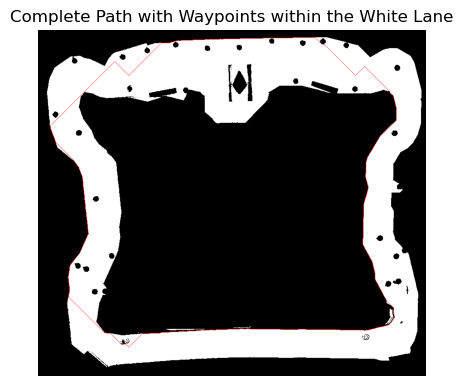

In [12]:
import numpy as np
import heapq
import matplotlib.pyplot as plt
import tracemalloc

file_path = r'C:\Users\boddu\Downloads\map_soc_walls_3_modified.npy'
soc1_map = np.load(file_path)

if soc1_map.ndim == 3:
    soc1_map = np.mean(soc1_map, axis=2)
binary_map = np.where(soc1_map > 128, 1, 0)  

start_provided = (700, 200)
waypoints_provided = [(100, 200), (100, 700)]
end_provided = (700, 200)

def find_nearest_white_lane(map_array, coord):
    x, y = coord
    if map_array[x, y] == 1:
        return coord
    
    directions = [(dx, dy) for dx in range(-1, 2) for dy in range(-1, 2)]
    radius = 1
    while radius < max(map_array.shape):
        for dx, dy in directions:
            new_x, new_y = x + dx * radius, y + dy * radius
            if 0 <= new_x < map_array.shape[0] and 0 <= new_y < map_array.shape[1]:
                if map_array[new_x, new_y] == 1:
                    return (new_x, new_y)
        radius += 1
    return None

start = find_nearest_white_lane(binary_map, start_provided)
waypoints = [find_nearest_white_lane(binary_map, wp) for wp in waypoints_provided]
end = find_nearest_white_lane(binary_map, end_provided)

print(f"Start: {start}")
print(f"Waypoints: {waypoints}")
print(f"End: {end}")


def dijkstra_with_bias(map_array, start, end):
    distances = {start: 0}
    priority_queue = [(0, start)]
    came_from = {start: None}
    
    directions = [(0, 1), (1, 0), (0, -1), (-1, 0), (-1,1), (1,1), (1,-1), (-1,-1)]
    
    while priority_queue:
        current_distance, current_node = heapq.heappop(priority_queue)
        
        if current_node == end:
            path = []
            while current_node:
                path.append(current_node)
                current_node = came_from[current_node]
            return path[::-1]   
            
        current_x, current_y = current_node
        for dx, dy in directions:
            neighbor = (current_x + dx, current_y + dy)
            neighbor_x, neighbor_y = neighbor

            if 0 <= neighbor_x < map_array.shape[0] and 0 <= neighbor_y < map_array.shape[1]:
                if map_array[neighbor_x, neighbor_y] == 1:
                    distance = current_distance + 1   
                    if distance < distances.get(neighbor, float('inf')):
                        distances[neighbor] = distance
                        heapq.heappush(priority_queue, (distance, neighbor))
                        came_from[neighbor] = current_node

    return None   

def find_combined_path(map_array, start, waypoints, end):
    
    combined_path = []

    for i in range(len(waypoints)):
        if i == 0:
            path_start_to_wp = dijkstra_with_bias(map_array, start, waypoints[i])
        else:
            path_start_to_wp = dijkstra_with_bias(map_array, waypoints[i-1], waypoints[i])

        if path_start_to_wp is not None:
            combined_path.extend(path_start_to_wp)

    path_wp_to_end = dijkstra_with_bias(map_array, waypoints[-1], end)
    if path_wp_to_end is not None:
        combined_path.extend(path_wp_to_end[1:])     

    return combined_path

tracemalloc.start()   
initial_memory = tracemalloc.get_traced_memory()[0]

path = find_combined_path(binary_map, start, waypoints, end)

final_memory = tracemalloc.get_traced_memory()[1]
tracemalloc.stop()   

memory_usage = final_memory - initial_memory
print(f"Memory usage: {memory_usage / (1024 * 1024)} MB")

if path is None:
    print("No valid complete path found within the white lane.")
else:
    visual_map = np.copy(binary_map)

    for (x, y) in path:
        visual_map[x, y] = 2  
    
    colors = {0: [0, 0, 0], 1: [255, 255, 255], 2: [255, 0, 0]}
    color_map = np.zeros((visual_map.shape[0], visual_map.shape[1], 3), dtype=np.uint8)

    for i in range(visual_map.shape[0]):
        for j in range(visual_map.shape[1]):
            color_map[i, j] = colors[visual_map[i, j]]
            
    plt.figure(figsize=(5, 5))
    plt.imshow(color_map)
    plt.title("Complete Path with Waypoints within the White Lane")
    plt.axis('off')
    plt.show()
